# Imports

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
from matplotlib import cm
from FAST_BSM import BlackScholesMerton as BSM

plt.style.use(['seaborn-ticks', 'fast'])

# Run benckmarks

In [2]:
# Strikes for a given expiry
strike_min = 3120
strike_max = 4630
strike_interval = 5 
period = 52

s = np.array([np.arange(strike_min, strike_max, strike_interval) for i in range(period)])

# Expiry times
time = np.linspace(1/period, period/period, period)

IR = 0.01
IV = 0.25
STRIKE = np.median([strike_min, strike_max])

# Option Array
I = np.ones((s.shape))
STRIKE_MAT = I*STRIKE
IR_mat = I*IR
IV_mat = I*IV
T = np.array([ele for ele in time for i in range(s.shape[1])]).reshape(s.shape)

In [3]:
%%timeit
# Run Benchmark
calls, puts = [], []
for i in range(s.shape[0]):
    for j in range(s.shape[1]):
        calls.append(BSM(
            option_type='c',
            price=s[i,j],
            strike=STRIKE_MAT[i,j],
            interest_rate=IR_mat[i,j],
            expiry=T[i,j],
            volatility=IV_mat[i,j]
        ))
        
        puts.append(BSM(
            option_type='p',
            price=s[i,j],
            strike=STRIKE_MAT[i,j],
            interest_rate=IR_mat[i,j],
            expiry=T[i,j],
            volatility=IV_mat[i,j]
        ))

68 ms ± 400 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [4]:
%%timeit
calls = [BSM('c', s[i,j], STRIKE_MAT[i,j], IR_mat[i,j], T[i,j], IV_mat[i,j]) for j in range(s.shape[1]) for i in range(s.shape[0])]
puts = [BSM('p', s[i,j], STRIKE_MAT[i,j], IR_mat[i,j], T[i,j], IV_mat[i,j]) for j in range(s.shape[1]) for i in range(s.shape[0])]

52.8 ms ± 258 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
%%time
calls = [BSM('c', s[i,j], STRIKE_MAT[i,j], IR_mat[i,j], T[i,j], IV_mat[i,j]) for i in range(s.shape[0]) for j in range(s.shape[1])]
puts = [BSM('p', s[i,j], STRIKE_MAT[i,j], IR_mat[i,j], T[i,j], IV_mat[i,j]) for i in range(s.shape[0]) for j in range(s.shape[1])]
print(f"Number Of Option Contracts: {len(calls)+len(puts):2,}")

Number Of Option Contracts: 31,408
CPU times: total: 62.5 ms
Wall time: 56 ms


## Option Prices

In [7]:
%%timeit
# Benchmark
calls_price = np.array([x.bsm_price() for x in calls]).reshape(s.shape)
puts_price = np.array([x.bsm_price() for x in puts]).reshape(s.shape)

363 ms ± 1.71 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%%time
# Benchmark
calls_price = np.array([x.bsm_price() for x in calls]).reshape(s.shape)
puts_price = np.array([x.bsm_price() for x in puts]).reshape(s.shape)

CPU times: total: 359 ms
Wall time: 366 ms


## Option Delta

In [9]:
%%timeit
# Benchmark
calls_delta = np.array([x.delta() for x in calls]).reshape(s.shape)
puts_delta = np.array([x.delta() for x in puts]).reshape(s.shape)

217 ms ± 1.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%%time
calls_delta = np.array([x.delta() for x in calls]).reshape(s.shape)
puts_delta = np.array([x.delta() for x in puts]).reshape(s.shape)

CPU times: total: 234 ms
Wall time: 220 ms


## Option Gamma

In [11]:
%%timeit
# Benchmark
calls_gamma = np.array([x.gamma() for x in calls]).reshape(s.shape)
puts_gamma = np.array([x.gamma() for x in puts]).reshape(s.shape)

275 ms ± 324 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%%time
calls_gamma = np.array([x.gamma() for x in calls]).reshape(s.shape)
puts_gamma = np.array([x.gamma() for x in puts]).reshape(s.shape)

CPU times: total: 281 ms
Wall time: 279 ms


## Option Vega

In [13]:
%%timeit
calls_vega = np.array([x.vega() for x in calls]).reshape(s.shape)
puts_vega = np.array([x.vega() for x in puts]).reshape(s.shape)

272 ms ± 999 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%%time
calls_vega = np.array([x.vega() for x in calls]).reshape(s.shape)
puts_vega = np.array([x.vega() for x in puts]).reshape(s.shape)

CPU times: total: 281 ms
Wall time: 273 ms


# Greek Surfaces

In [22]:
figsize = [13, 10]

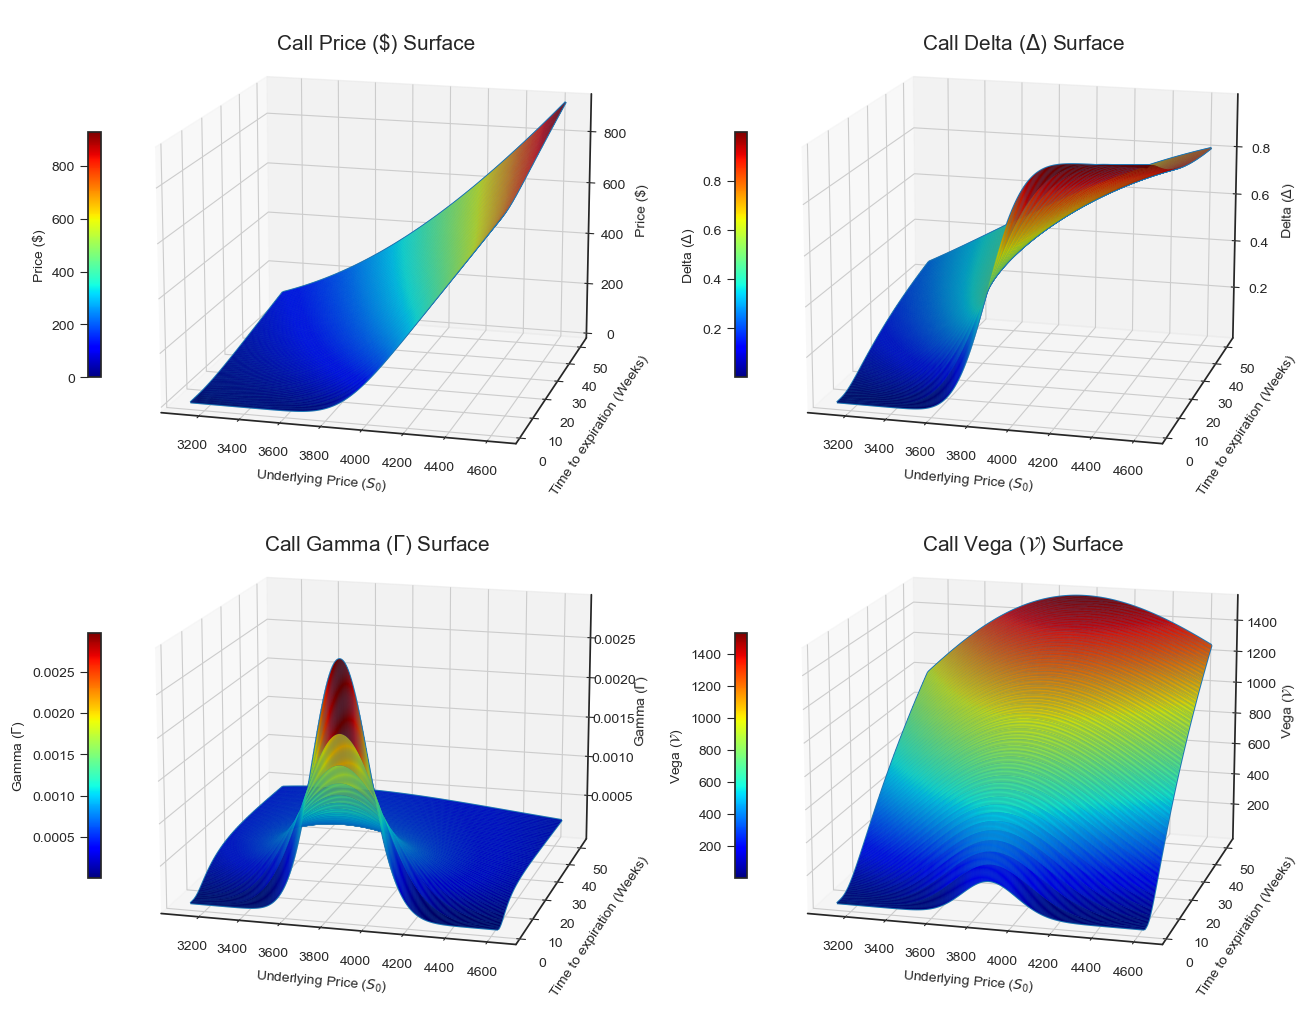

In [23]:
greeks = [
    calls_price,
    calls_delta,
    calls_gamma,
    calls_vega
]

greek_names = ['Price ($)', 'Delta ($\Delta$)', 'Gamma ($\Gamma$)', 'Vega ($\mathcal{V}$)']

fig = plt.figure(figsize=figsize, constrained_layout=True)
count = 1
for greek in greeks:
    norm = matplotlib.colors.Normalize() 
    ax = fig.add_subplot(int(f"22{count}"), projection='3d')
    ax.view_init(15, -75)
    ax.dist = 9
    
    ax.plot_wireframe(s, T*52, greek, rstride=1, cstride=1)
    ax.plot_surface(s, T*52, greek, facecolors=cm.jet(norm(greek)), linewidth=0.001, rstride=1, cstride=1)
    ax.set_zlim3d(greek.min(), greek.max())

    count -= 1
    
    plt.title(f"Call {greek_names[count]} Surface", size=15, y=0.98)
    ax.set_xlabel('Underlying Price ($S_0$)')
    ax.set_ylabel('Time to expiration (Weeks)')
    ax.set_zlabel(f'{greek_names[count]}')
    
    m = cm.ScalarMappable(cmap=cm.jet)
    m.set_array(greek)
    cbar = plt.colorbar(m, shrink=0.5, ax=ax, label=f'{greek_names[count]}', location='left')
    count += 2

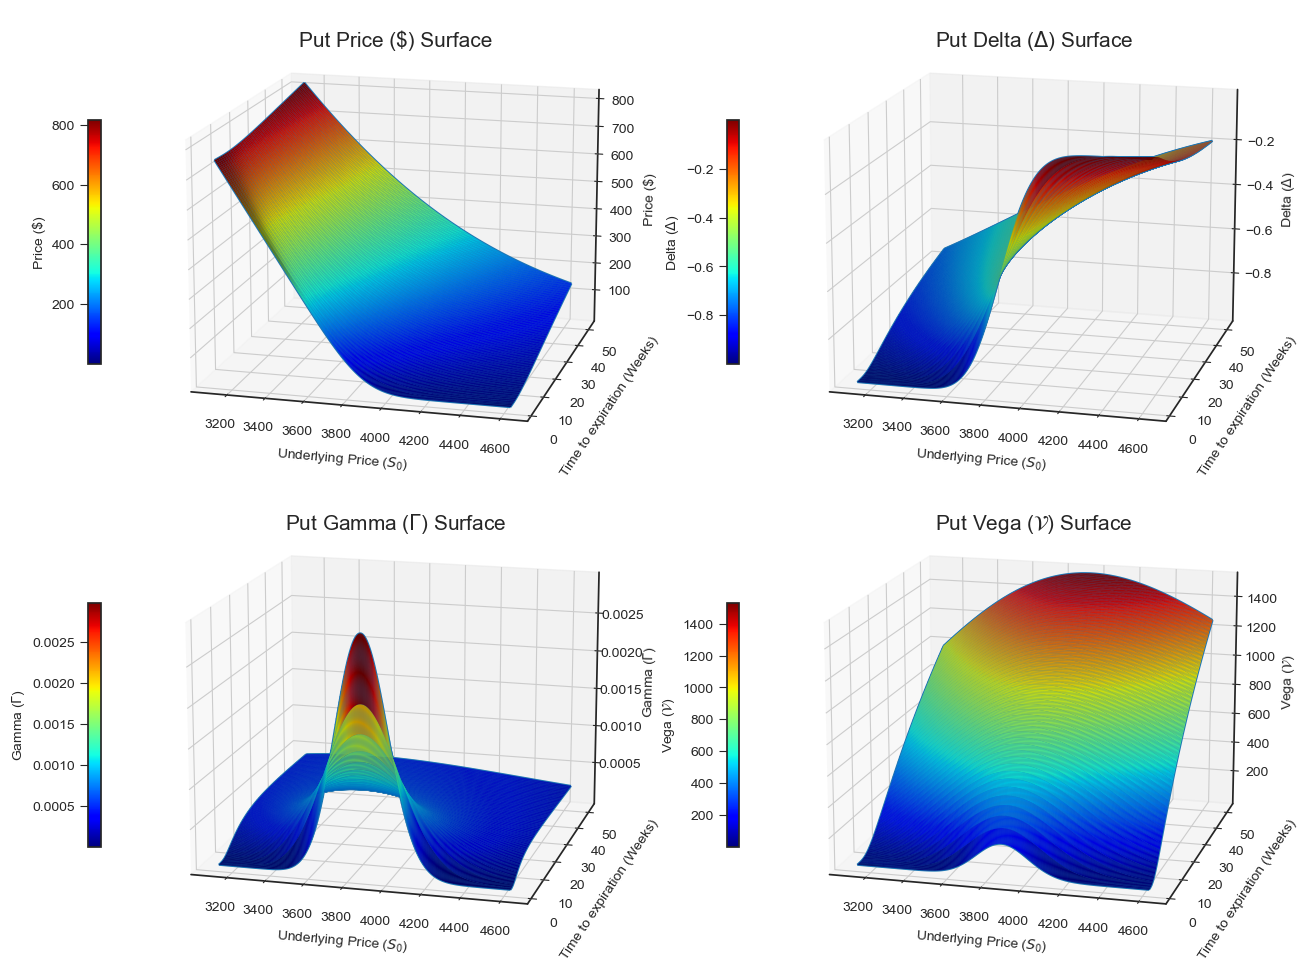

In [24]:
greeks = [
    puts_price,
    puts_delta,
    puts_gamma,
    puts_vega
]

greek_names = ['Price ($)', 'Delta ($\Delta$)', 'Gamma ($\Gamma$)', 'Vega ($\mathcal{V}$)']

fig = plt.figure(figsize=figsize, constrained_layout=True)
count = 1
for greek in greeks:
    norm = matplotlib.colors.Normalize() 
    ax = fig.add_subplot(int(f"22{count}"), projection='3d')
    ax.view_init(15, -75)
    ax.dist = 9
    
    ax.plot_wireframe(s, T*52, greek, rstride=1, cstride=1)
    ax.plot_surface(s, T*52, greek, facecolors=cm.jet(norm(greek)), linewidth=0.001, rstride=1, cstride=1)
    ax.set_zlim3d(greek.min(), greek.max())

    count -= 1
    
    plt.title(f"Put {greek_names[count]} Surface", size=15, y=0.98)
    ax.set_xlabel('Underlying Price ($S_0$)')
    ax.set_ylabel('Time to expiration (Weeks)')
    ax.set_zlabel(f'{greek_names[count]}')
    
    m = cm.ScalarMappable(cmap=cm.jet)
    m.set_array(greek)
    cbar = plt.colorbar(m, shrink=0.5, ax=ax, label=f'{greek_names[count]}', location='left')
    count += 2